![](https://storage.googleapis.com/kaggle-competitions/kaggle/49200/logos/header.png)

# <span style="color: gold;">Playground Series - Season 3, Episode 12</span>
## <span style="color: orange;">Binary Classification with a Kidney Stone Prediction Dataset</span>

### <span style="color: #00BFFF;">Welcome to the 2023 edition of Kaggle's Playground Series!</span>
Thank you to everyone who participated in and contributed to Season 3 Playground Series so far!

With the same goal to give the Kaggle community a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science, we will continue launching the Tabular Tuesday in April every Tuesday 00:00 UTC, with each competition running for 2 weeks. Again, these will be fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc..

### <span style="color: #00BFFF;">Synthetically-Generated Datasets</span>
Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### <span style="color: #00BFFF">Submission File</span>
For each id in the test set, you must predict the probability of target (likelihood of the presence of a kidney stone). The file should contain a header and have the following format:

```Python
id,target
414,0.5
415,0.1
416,0.9
etc.
```

In [1]:
# 1 - import the necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier

In [2]:
# 2 - open training and test data
train = pd.read_csv('E:\Kaggle\Playground Series S3-E12/train.csv')
test = pd.read_csv('E:\Kaggle\Playground Series S3-E12/test.csv')
train.head(3)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0


In [3]:
# 3 - display a list of features
train.columns.tolist()

['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']

In [4]:
# 4 - see dataset size
train.shape

(414, 8)

In [5]:
# 5 - display descriptive statistics of training data
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [6]:
# 6 - check the number of gaps for each feature
train.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [7]:
# 7 - look at the data type of the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [8]:
# 8 - build a heat map of correlations (sns.heatmap produced anomalous errors)
correlation = train.corr()
correlation.style.background_gradient(cmap='coolwarm')

,id,gravity,ph,osmo,cond,urea,calc,target
id,1.000000,-0.004775,-0.086619,0.008030,0.032843,-0.023822,0.032360,0.018222
gravity,-0.004775,1.000000,-0.290349,0.692317,0.470433,0.631710,0.494304,0.282577
ph,-0.086619,-0.290349,1.000000,-0.309495,-0.190185,-0.279749,-0.214402,-0.094983
osmo,0.008030,0.692317,-0.309495,1.000000,0.708480,0.809880,0.472114,0.244770
cond,0.032843,0.470433,-0.190185,0.708480,1.000000,0.499109,0.330609,0.172224
urea,-0.023822,0.631710,-0.279749,0.809880,0.499109,1.000000,0.489879,0.265211
calc,0.032360,0.494304,-0.214402,0.472114,0.330609,0.489879,1.000000,0.467439
target,0.018222,0.282577,-0.094983,0.244770,0.172224,0.265211,0.467439,1.000000


In [9]:
# 9 - remove 'osmo' feature to reduce correlation to avoid multicolinearity
correlation = train.drop(columns='osmo', axis=1).corr()
train.drop(columns='osmo', axis=1, inplace=True)
correlation.style.background_gradient(cmap='summer')

,id,gravity,ph,cond,urea,calc,target
id,1.000000,-0.004775,-0.086619,0.032843,-0.023822,0.032360,0.018222
gravity,-0.004775,1.000000,-0.290349,0.470433,0.631710,0.494304,0.282577
ph,-0.086619,-0.290349,1.000000,-0.190185,-0.279749,-0.214402,-0.094983
cond,0.032843,0.470433,-0.190185,1.000000,0.499109,0.330609,0.172224
urea,-0.023822,0.631710,-0.279749,0.499109,1.000000,0.489879,0.265211
calc,0.032360,0.494304,-0.214402,0.330609,0.489879,1.000000,0.467439
target,0.018222,0.282577,-0.094983,0.172224,0.265211,0.467439,1.000000


In [10]:
# 10 - set up visualization
sns.set(rc={'figure.figsize': (18, 12)})

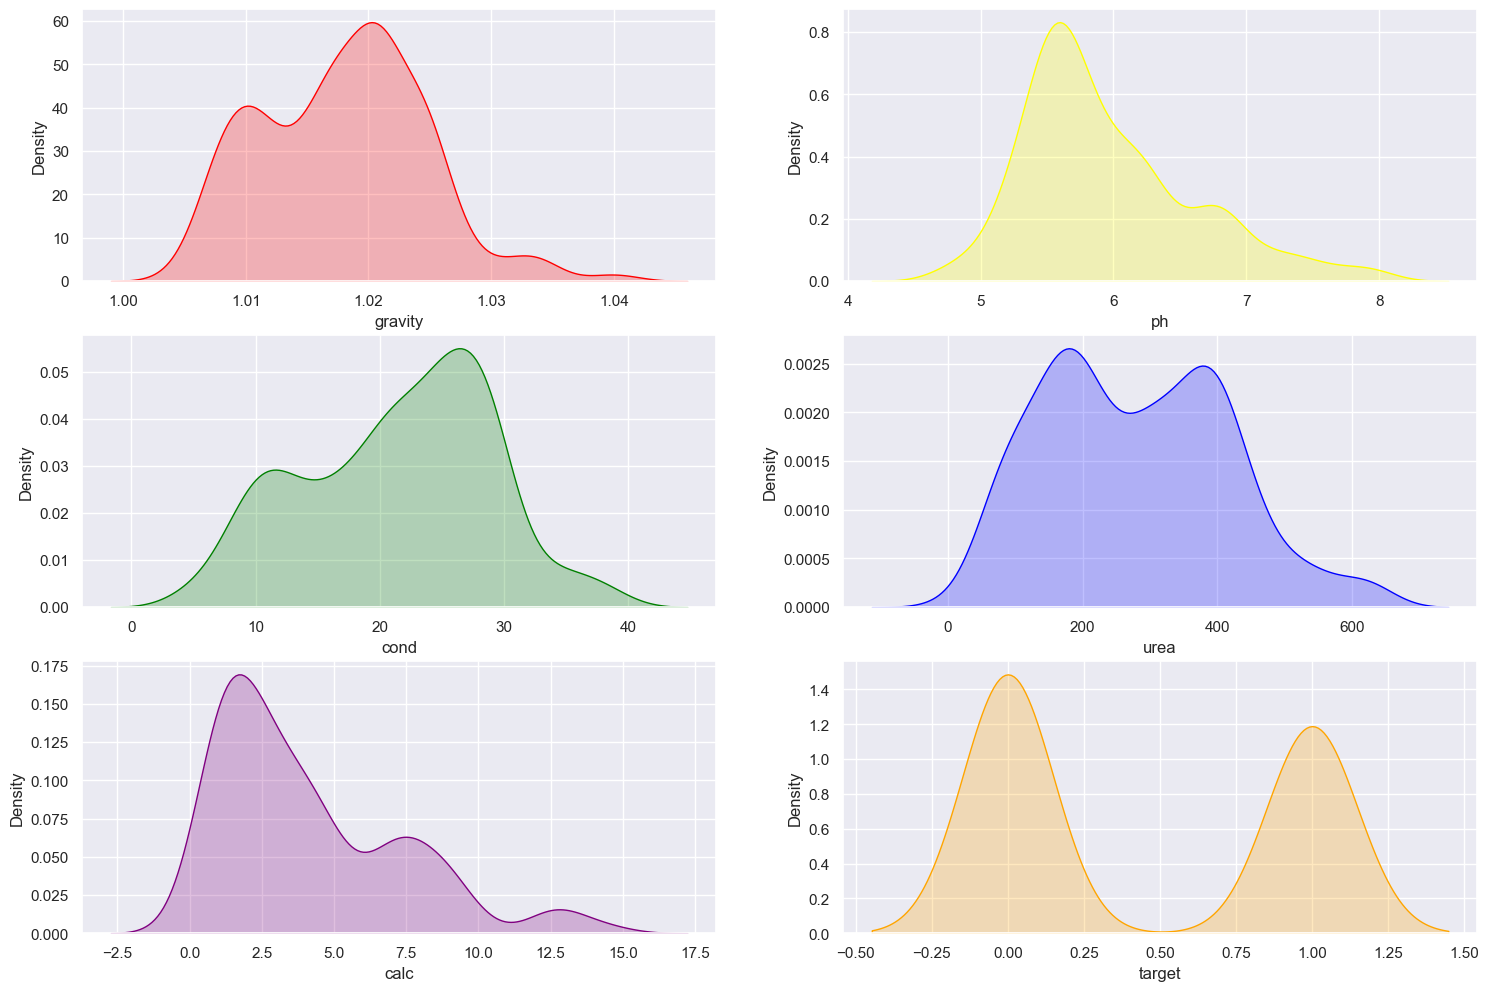

In [11]:
# 11 - let's look at the distributions of features
plt.subplot(3, 2, 1)
sns.kdeplot(data=train['gravity'], color='red', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(data=train['ph'], color='yellow', fill=True);

plt.subplot(3, 2, 3)
sns.kdeplot(data=train['cond'], color='green', fill=True);

plt.subplot(3, 2, 4)
sns.kdeplot(data=train['urea'], color='blue', fill=True);

plt.subplot(3, 2, 5)
sns.kdeplot(data=train['calc'], color='purple', fill=True);

plt.subplot(3, 2, 6)
sns.kdeplot(data=train['target'], color='orange', fill=True);

In [12]:
# 12 - split the training dataset into X and y
X = train.drop(['id', 'target'], axis=1)
y = train['target']

In [13]:
# 13 - split the training data into training and validation (test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
# 14 - standardize data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
test_data = test.drop(columns=['id', 'osmo'], axis=1)

In [15]:
# 15 - train the CatBoost Classifier model
clf = CatBoostClassifier(max_depth=10)
clf.fit(X_train_std, y_train)

Learning rate set to 0.006425
0:	learn: 0.6903163	total: 162ms	remaining: 2m 41s
1:	learn: 0.6869151	total: 184ms	remaining: 1m 31s
2:	learn: 0.6840545	total: 199ms	remaining: 1m 6s
3:	learn: 0.6806963	total: 211ms	remaining: 52.6s
4:	learn: 0.6773350	total: 220ms	remaining: 43.7s
5:	learn: 0.6757462	total: 221ms	remaining: 36.6s
6:	learn: 0.6727311	total: 228ms	remaining: 32.3s
7:	learn: 0.6701266	total: 234ms	remaining: 29.1s
8:	learn: 0.6672628	total: 241ms	remaining: 26.6s
9:	learn: 0.6641715	total: 249ms	remaining: 24.6s
10:	learn: 0.6610686	total: 256ms	remaining: 23s
11:	learn: 0.6583863	total: 262ms	remaining: 21.5s
12:	learn: 0.6554395	total: 267ms	remaining: 20.3s
13:	learn: 0.6531356	total: 273ms	remaining: 19.2s
14:	learn: 0.6505785	total: 279ms	remaining: 18.3s
15:	learn: 0.6480209	total: 284ms	remaining: 17.5s
16:	learn: 0.6450622	total: 290ms	remaining: 16.8s
17:	learn: 0.6419351	total: 295ms	remaining: 16.1s
18:	learn: 0.6394522	total: 301ms	remaining: 15.5s
19:	learn: 

In [16]:
# 16 - get a prediction on test data
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)

# get class labels
y_pred_test

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int64)

In [17]:
# 17 - Calculate Precision, Recall, F1 and ROC-AUC metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# precision for test data
print(f'precision: {precision_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'recall: {recall_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'F1: {f1_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_test):.4f}')

precision: 0.6842

recall: 0.7027

F1: 0.6933

ROC-AUC: 0.7209


In [18]:
# 18 - P.S. Metrics can also be obtained in another way
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        46
           1       0.68      0.70      0.69        37

    accuracy                           0.72        83
   macro avg       0.72      0.72      0.72        83
weighted avg       0.72      0.72      0.72        83



In [19]:
# 19 - create ensemble from 15 models
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# create instances of machine learning models and determine their hyperparameters
warnings.filterwarnings('ignore')
model1 = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)
model3 = SVC(kernel='linear', C=1)
model4 = SVC(kernel='rbf', C=0.1, gamma=0.1)
model5 = LogisticRegression(penalty='l2', C=1)
model6 = LogisticRegression(penalty='l2', C=0.1)
model7 = GaussianNB(var_smoothing=1e-09)
model8 = KNeighborsClassifier(n_neighbors=5)
model9 = KNeighborsClassifier(n_neighbors=10)
model10 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5)
model11 = MLPClassifier(hidden_layer_sizes=(50,50), solver='adam', activation='relu', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model12 = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, subsample=0.5, colsample_bytree=0.5)
model13 = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=10, subsample=0.8, colsample_bytree=0.8)
model14 = LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.05, n_estimators=100, max_depth=10, num_leaves=31)
model15 = LGBMClassifier(boosting_type='dart', objective='binary', learning_rate=0.01, n_estimators=200, max_depth=7, num_leaves=63)

models = [('dt1', model1), ('dt2', model2), ('svc1', model3), ('svc2', model4), ('lr1', model5), ('lr2', model6), 
          ('gnb', model7), ('knn1', model8), ('knn2', model9), ('rf', model10), ('mlp', model11), ('xgb1', model12),
          ('xgb2', model13), ('lgbm1', model14), ('lgbm2', model15)]

ensemble = VotingClassifier(models)

# train the ensemble on the training data
ensemble.fit(X_train, y_train)
predict = ensemble.predict(test_data)
predict

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int64)

In [20]:
# 20 - create ensemble from 20 models
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# create instances of machine learning models and determine their hyperparameters
warnings.filterwarnings('ignore')
model1 = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)
model3 = SVC(kernel='linear', C=1)
model4 = SVC(kernel='rbf', C=0.1, gamma=0.1)
model5 = LogisticRegression(penalty='l2', C=1)
model6 = LogisticRegression(penalty='l2', C=0.1)
model7 = GaussianNB(var_smoothing=1e-09)
model8 = KNeighborsClassifier(n_neighbors=5)
model9 = KNeighborsClassifier(n_neighbors=10)
model10 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5)
model11 = MLPClassifier(hidden_layer_sizes=(50,50), solver='adam', activation='relu', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model12 = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, subsample=0.5, colsample_bytree=0.5)
model13 = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=10, subsample=0.8, colsample_bytree=0.8)
model14 = LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.05, n_estimators=100, max_depth=10, num_leaves=31)
model15 = LGBMClassifier(boosting_type='dart', objective='binary', learning_rate=0.01, n_estimators=200, max_depth=7, num_leaves=63)
model16 = RandomForestClassifier(n_estimators=50, max_depth=5)
model17 = MLPClassifier(hidden_layer_sizes=(25,25), solver='adam', activation='logistic', alpha=0.01, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model18 = KNeighborsClassifier(n_neighbors=3)
model19 = XGBClassifier(learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8)
model20 = DecisionTreeClassifier(criterion='gini', max_depth=3)

models = [('dt1', model1), ('dt2', model2), ('svc1', model3), ('svc2', model4), ('lr1', model5), ('lr2', model6), 
          ('gnb', model7), ('knn1', model8), ('knn2', model9), ('rf', model10), ('mlp', model11), ('xgb1', model12),
          ('xgb2', model13), ('lgbm1', model14), ('lgbm2', model15), ('rf2', model16), ('mlp2', model17), 
          ('knn3', model18), ('xgb3', model19), ('dt3', model20)]

ensemble = VotingClassifier(models)

# train the ensemble on the training data
ensemble.fit(X_train, y_train)
predict = ensemble.predict(test_data)
predict

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int64)

In [21]:
# 21 - making submission's dataset
submission = pd.DataFrame()
submission['id'] = test.id
submission['target'] = predict
submission

,id,target
0,414,0
1,415,0
2,416,1
3,417,0
4,418,0
...,...,...
271,685,1
272,686,0
273,687,1
274,688,0


In [22]:
# 22 - making submission's csv file
submission.to_csv('20 models ensemble submission PSs3e12.csv', index=False)